In [171]:
cd ..

/Users/jwen/Stanford/projects/smoke_segmentation


In [172]:
cd src

/Users/jwen/Stanford/projects/smoke_segmentation/src


In [173]:
#from metrics import lovasz as lov_loss
import torch
import time
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from utils.data_set import WildfireSmokeDataset
from utils import data_vis
from utils import augmentation as aug
from matplotlib import pyplot as plt

%matplotlib inline

In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading in data

In [131]:
train_dataset = WildfireSmokeDataset('../data/crops_unfiltered/file_index.csv', 
                     root_dir='crops_unfiltered',train_val_test='train', 
                                     bands=['true_color','C07','C11','merra2'], 
                                     #bands=['true_color','C07','C11'], 
                                     #bands=['true_color', 'C07'],
                                     #bands=['true_color'], 
                                     #transform=None)
                                     transform=transforms.Compose([aug.ToTensorTarget()]))

In [132]:
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=True)

In [133]:
blah = next(iter(train_loader))
#blah = next(iter(train_dataset))

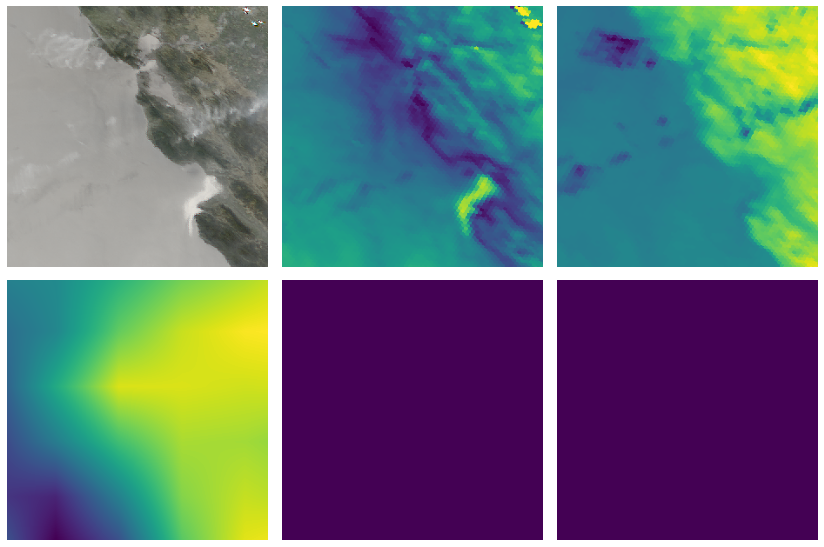

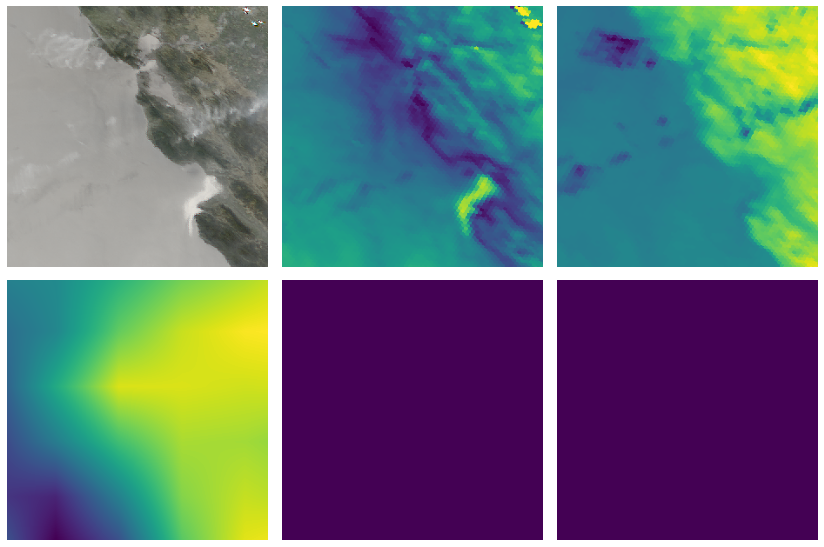

In [134]:
data_vis.show_tensorboard_image(blah['sat_img'], blah['map_img'], blah['map_img'])

In [52]:
zing = io.imread('../data/crops/train/true_color_G16_doy321_s201811172357_e201811172359_7.png')
blah = io.imread('../data/crops/train/C07_G16_doy321_s201811172357_e201811172359_7.png')

In [57]:
np.dstack([zing, blah[:,:,0], blah[:,:,0]]).shape

(300, 300, 5)

In [267]:
blah = train_dataset[0]['map_img']

In [103]:
ax.shape

(2, 3)

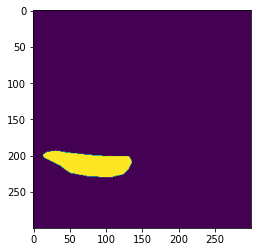

In [278]:
plt.imshow(blah[2,:,:].cpu().numpy())

## Predict using trained model
* Load model, predict on full size images

In [187]:
import glob
import os
import pandas as pd

from models import unet
from utils import helpers as h

## gather image filenames for true_color (which each has corresponding channel/ masks)
imgs = glob.glob(f'../data/img/test_img/true_color*')

In [188]:
file_dict = {'true_color':[], 'C07': [], 'C11':[], 'mask': [], 'merra2': [], 'train_val_test': []}
for file_str in imgs:
    
    img_slug = '_'.join(os.path.basename(file_str).split('_')[:6])
    
    file_dict['true_color'] += [file_str.split('/')[-1]]
    file_dict['C07'] += [f"C07_{'_'.join(file_str.split('/')[-1].split('_')[2:])}"]
    file_dict['C11']+= [f"C11_{'_'.join(file_str.split('/')[-1].split('_')[2:])}"]
    file_dict['mask'] += [f"mask_{'_'.join(file_str.split('/')[-1].split('_')[2:])}"]
    
    # get file name for merra2
    fname_params = h.get_true_color_filename_split_dict(file_str)
    true_color_fn = file_str.split('/')[-1]
    start_end_slug = true_color_fn.split('_')[4] +'_'+ true_color_fn.split('_')[5].split('.')[0]
    file_dict['merra2'] += [f"merra2_{fname_params['year']}{fname_params['month']}{fname_params['day']}_{start_end_slug}.npy"]
    
    file_dict['train_val_test'] += ['test_img']
    
file_df = pd.DataFrame.from_dict(file_dict)

In [189]:
file_df

,true_color,C07,C11,mask,merra2,train_val_test
0,true_color_G16_doy217_s201808051730_e201808051...,C07_G16_doy217_s201808051730_e201808051741.tiff,C11_G16_doy217_s201808051730_e201808051741.tiff,mask_G16_doy217_s201808051730_e201808051741.tiff,merra2_20180805_s201808051730_e201808051741.npy,test_img


In [201]:
from PIL import Image
np.array(Image.open('../data/img/test_img/true_color_G16_doy217_s201808051730_e201808051741.tiff'))[:,:,0:3].shape

(1200, 1200, 3)

In [273]:
bands = ['true_color', 'C07', 'C11', 'merra2']

# read in images
temp_img_list = []

for band in bands:

    temp_img_name = f'../data/img/test_img/{band}_G16_doy217_s201808051730_e201808051741.tiff'

    if band == 'merra2':
        try:
            temp_img_name = f'../data/img/test_img/{band}_20180805.tiff'
            
            # clip values to between 0 and 5 for merra2
            merra2_img = np.clip(np.array(Image.open(temp_img_name)), a_min=0, a_max=5)
        except ValueError:
            print(f"error reading: {temp_img_name}")

    else:
        temp_img = np.array(Image.open(temp_img_name))

        # add image to dict
        if band == 'true_color':
            temp_img_list.append(temp_img[:,:,0:3])

        elif band in ['C07', 'C11']:

            # repeated values for the other bands...
            temp_img_list.append(temp_img[:,:,0])


# create numpy image array with all channels
sat_image = np.dstack(temp_img_list)    

transform = transforms.ToTensor()
sat_image = transform(sat_image)

# transfrom merra2 separately cause of different scales
if 'merra2' in bands:
    #merra2_img = transforms.functional.to_tensor(merra2_img)
    merra2_img = transforms.functional.normalize(torch.as_tensor(merra2_img).unsqueeze(0), mean=[0.13749852776527405], std=[0.042889975011348724])

    # concatenate merra2 onto sat image
    sat_image = torch.cat((sat_image, merra2_img), dim=0)

In [275]:
## define model class
model = unet.UNetSmall(num_channels=len(bands)+2)
model_dict = torch.load('../checkpoints/best_run4.pth.tar', map_location=torch.device('cpu'))

model.load_state_dict(model_dict['state_dict'])
model.eval()

UNetSmall(
  (conv1): encoding_block(
    (encoding_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): PReLU(num_parameters=1)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (6): PReLU(num_parameters=1)
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): encoding_block(
    (encoding_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): PReLU(num_parameters=1)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(64, 64, kernel_size=(3, 3)

In [276]:
out_pred_raw = model(sat_image.unsqueeze(0))

In [277]:
out_image = torch.nn.functional.sigmoid(out_pred_raw)

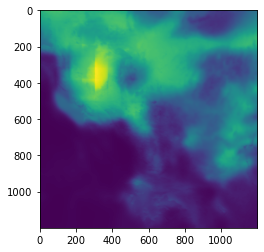

In [278]:
out_probs = out_image[0,0,:,:].detach().numpy()
plt.imshow(out_probs)

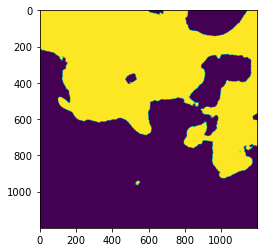

In [279]:
out_map = (out_image > 0.3).int()[0,0,:,:].detach().numpy()
plt.imshow(out_map)

In [280]:
## save mask and pred images
im = Image.fromarray(out_probs)
im.save('../data/img/out_img/pred_probs_G16_doy217_s201808051730_e201808051741_with_merra.tiff')

In [281]:
im = Image.fromarray((out_map*255).astype(np.uint8))
im.save('../data/img/out_img/pred_map_G16_doy217_s201808051730_e201808051741_with_merra.png')

## Read in `.png` and crop to CA/NV

In [282]:
import rasterio

In [304]:
test_src = rasterio.open('../data/img/test_img/true_color_G16_doy217_s201808051730_e201808051741.tiff')
src = rasterio.open('../data/img/true_color_G16_doy250_s201809071902_e201809071904.png')

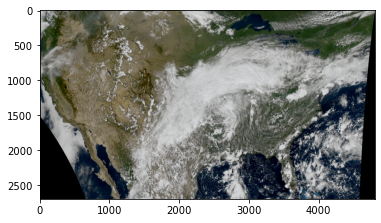

In [291]:
test_src.bounds

BoundingBox(left=-124.48200299999999, bottom=32.528832, right=-114.131211, top=42.009502999999995)

In [292]:
test_src.crs

CRS.from_epsg(4326)

In [293]:
test_src.transform

Affine(0.008625659999999999, 0.0, -124.48200299999999,
       0.0, -0.007900559166666661, 42.009502999999995)

In [299]:
crs = rasterio.crs.CRS.from_epsg(4326)

In [302]:
src.crs = crs

DatasetAttributeError: read-only attribute

In [373]:
from shapely.geometry import box
from rasterio.mask import mask
import geopandas as gpd
from fiona.crs import from_epsg

In [415]:
bands = [1,2,3]
in_west, in_south, in_east, in_north = (-124.5, 24.4, -66.6, 49.3)
out_west, out_south, out_east, out_north = (-124.48200299999999, 32.528832, -114.131211, 42.009502999999995)

transform = rasterio.transform.from_bounds(in_west, in_south, in_east, in_north, width=4800,height=2700)
window = rasterio.windows.from_bounds(out_west, out_south, out_east, out_north, transform)

out_width = 1200
out_height = 1200

with rasterio.open('../data/img/trial_img.png', mode='r+') as src:

    with rasterio.open('../data/img/trial_img_cropped.png', 'w', driver='PNG',
                       width=out_width, height=out_height,
                       count=3, dtype=data.dtype, crs=crs) as dst:
        dst.write(src.read(bands, window=window), indexes=bands)

        
#     src.transform = transform
#     src.crs = crs
    
#     with rasterio.open('../data/img/trial_img_cropped.tiff', 'w', driver='GTiff',
#                        width=out_width, height=out_height,
#                        #width=data.shape[1], height=data.shape[2],
#                        count=3, dtype=data.dtype,
#                        crs=crs) as dst:
#         dst.write(src.read(bands, window=window), indexes=bands)

# crop_transform = rasterio.transform.from_bounds(out_west, out_south, out_east, out_north, width=out_width, height=out_height)
        
# crs = {'init': 'epsg:4326'}
#     #bbox = [box(out_west, out_south, out_east, out_north, ccw=True)]
#     out_image, out_transform = mask(src, geo.geometry, crop=True)
#     out_meta = src.meta
    
#     out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "transform": out_transform})
    
#     with rasterio.open('../data/img/trial_img_cropped.tiff', "w", **out_meta) as dst:
#         dst.write(out_image, indexes=bands)
        
#     height, width = src.shape
#     with rasterio.open('../data/img/trial_img.tiff', 'w', driver='GTiff',
#                        width=width, height=height,
#                        count=3, dtype=data.dtype, nodata=0,
#                        transform=transform, crs=crs) as dst:
#         dst.write(data, indexes=bands)

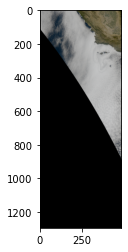

In [384]:
plt.imshow(out_image[0:3,:,:].transpose(1,2,0))

In [411]:
with rasterio.open('../data/img/trial_img.tiff', mode='r+') as src:
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    with rasterio.open('../data/img/trial_img_cropped.tiff', "w", **out_meta) as dst:
        dst.write(out_image[0:3,:,:], indexes=bands)

In [404]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 4800,
 'height': 2700,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.021444444444444447, 0.0, -124.5,
        0.0, -0.005187499999999999, 49.3)}

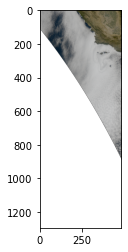

<AxesSubplot:>

In [401]:
from rasterio.plot import show
show(out_image)

In [409]:
data.shape[2]

4800